In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import random

import gym
from gym import spaces
import keras
from keras.layers import *
from keras.models import Model
import numpy
import rl
import scipy.sparse
import skimage.io

import sys
print(sys.version)

%matplotlib inline

Using TensorFlow backend.


3.6.5 (default, Apr  1 2018, 05:46:30) 
[GCC 7.3.0]


In [3]:
input_neurons = 8
inter_neurons = 128
output_neurons = 8
max_history = 16
hidden_size = 32

In [4]:
def hebbian(history):
    return numpy.tanh(numpy.vectorize(lambda x: -1/5*(x-5))(history))

In [20]:
class SNN(gym.Env):
    
    def __init__(self, specification):
        self.specification = specification
        self.total_neurons = self.specification['input_neurons'] + self.specification['inter_neurons'] + self.specification['output_neurons']
        self.observation_space = gym.spaces.Box(-1, float('inf'), ((self.specification['inter_neurons'] + self.specification['output_neurons']) * (1 + 2 * (self.specification['input_neurons'] + self.specification['inter_neurons'])),), dtype=float)
        self.action_space = gym.spaces.Box(-1, 1, ((self.specification['inter_neurons'] + self.specification['output_neurons']) * (2 * (self.specification['input_neurons'] + self.specification['inter_neurons'])),), dtype=float)
#         self.observation_space = gym.spaces.Tuple((gym.spaces.Box(-1, 1, (self.specification['input_neurons'] + self.specification['inter_neurons'],)), gym.spaces.Box(-1, 1, (self.specification['input_neurons'] + self.specification['inter_neurons'],))))
        self.potential_matrix = numpy.zeros((self.total_neurons,))
        self.weight_matrix = numpy.zeros((self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['input_neurons'] + self.specification['inter_neurons']))
        self.weight_mask = numpy.ones_like(self.weight_matrix, dtype=numpy.uint8)
        self.weight_mask[-self.specification['output_neurons']:, :self.specification['input_neurons']] = 0
        numpy.fill_diagonal(self.weight_mask[:self.specification['inter_neurons'], -self.specification['inter_neurons']:], 0)
        self.history_matrix = numpy.zeros((self.specification['inter_neurons'] + self.specification['output_neurons'], 1 + 2 * (self.specification['input_neurons'] + self.specification['inter_neurons'])))
        self.random_seed = None
        self.next_input = None
        self.previous_reward = None
    
    def interconnect(self):
        self.weight_matrix = numpy.zeros_like(self.weight_matrix)
        probabilities = numpy.vectorize(lambda i, j: 1 / abs(i - j) if i != j else 0.)(*numpy.meshgrid(range(self.specification['inter_neurons']), range(self.specification['inter_neurons'])))
        mask = numpy.zeros((self.weight_matrix.shape[0], self.weight_matrix.shape[1]))
        mask[:-self.specification['output_neurons'], self.specification['input_neurons']:] = numpy.random.binomial(1, probabilities, (self.specification['inter_neurons'], self.specification['inter_neurons']))
        mask[:self.specification['inter_neurons'], :self.specification['input_neurons']] = numpy.eye(self.specification['inter_neurons'])[numpy.random.choice(self.specification['inter_neurons'], self.specification['input_neurons'])].swapaxes(0, 1)
        mask[self.specification['inter_neurons']:, self.specification['input_neurons']:] = numpy.eye(self.specification['inter_neurons'])[numpy.random.choice(self.specification['inter_neurons'], self.specification['output_neurons'])]
        rand1 = numpy.random.uniform(0, 1, (self.weight_matrix.shape[0], self.weight_matrix.shape[1]))
        rand1[:-self.specification['output_neurons'], self.specification['input_neurons']:] = rand1[:-self.specification['output_neurons'], self.specification['input_neurons']:] * 2 - 1
        rand2 = numpy.random.uniform(0, 1, (self.weight_matrix.shape[0], self.weight_matrix.shape[1]))
        self.weight_matrix = mask * rand1 * rand2 * self.weight_mask
#         self.sign_matrix = numpy.sign(self.weight_matrix)
    
    def load_weights(self, weights):
        self.weight_matrix[:, :] = weights
        self.sign_matrix[:, :] = numpy.sign(self.weight_matrix)
    
    def close(self):
        self.specification['environment'].close()
        
    def reset(self): # resets encapsulating environment, not the SNN
        self.next_input = self.specification['environment'].reset()
        return self.history_matrix.flatten()
    
    def render(self, mode='human'):
        return self.specification['environment'].render(mode)
    
    def seed(self, seed):
        numpy.random.seed(seed)
        self.random_seed = seed
        return self.specification['environment'].seed(self.random_seed)
    
    def step(self, action):
#         self.next_input = np.eye(self.specification['input_neurons'])[np.random.choice(self.specification['input_neurons'], 1)]
        if self.specification['neuroplasticity']:
            action = action.reshape((self.specification['inter_neurons'] + self.specification['output_neurons'], 2 * (self.specification['input_neurons'] + self.specification['inter_neurons'])))
            self.weight_matrix += self.specification['learning_rate'] * numpy.round(action[:, self.specification['input_neurons'] + self.specification['inter_neurons']:]) * action[:, :self.specification['input_neurons'] + self.specification['inter_neurons']]
            self.weight_matrix = numpy.clip(numpy.multiply(self.weight_matrix, self.weight_mask), -1, 1)
#         state = numpy.zeros_like(self.history_matrix[self.neuron_idx, :])
#         reward = 0
#         terminal = False
        self.potential_matrix[:self.specification['input_neurons']] = numpy.add(self.potential_matrix[:self.specification['input_neurons']], self.next_input)
        firing_matrix = numpy.vectorize(lambda x: x >= 1)(self.potential_matrix)
        for i in range(self.specification['inter_neurons'] + self.specification['output_neurons']):
            pos = self.specification['input_neurons'] + i
            deltas = numpy.multiply(firing_matrix[:-self.specification['output_neurons']], self.weight_matrix[i])
            delta = numpy.sum(deltas)
            if self.specification['neuroplasticity']:
                self.history_matrix[i, self.specification['input_neurons'] + self.specification['inter_neurons']:] += 1
                self.history_matrix[i, self.specification['input_neurons'] + self.specification['inter_neurons']:-1] *= firing_matrix[:-self.specification['output_neurons']]
                self.history_matrix[i, -1] *= firing_matrix[pos]
                self.history_matrix[i, :self.specification['input_neurons'] + self.specification['inter_neurons']] = self.weight_matrix[i]
#                 self.history_matrix[i, self.weight_idx, self.specification['max_history'] - 1, :] = numpy.array([deltas[self.weight_idx], delta, self.potential_matrix[pos], firing_matrix[pos]])
            self.potential_matrix[pos] += delta
        self.potential_matrix = numpy.clip(numpy.multiply(self.potential_matrix, numpy.invert(firing_matrix)), -1, 1)
#         if self.specification['neuroplasticity']:
#             self.history_matrix = numpy.roll(self.history_matrix, 2, axis=1)
        state = self.history_matrix.flatten()
        self.next_input, reward, terminal, _ = self.specification['environment'].step(firing_matrix[-self.specification['output_neurons']:].astype(int))
        return state, reward, terminal, {}

In [6]:
class Test(gym.Env):
    
    def __init__(self):
        self.action_space = gym.spaces.Box(0, 1, (8,))
        self.observation_space = gym.spaces.Box(0, float('inf'), (8,))

    def close(self):
        pass

    def reset(self):
        self.state = numpy.zeros((8,))
        self.idx = 0
        return self.state

    def step(self, action):
        self.state = numpy.add(self.state, action)
        reward = ((self.state[1] - self.state[0]) * (self.state[2] - self.state[3])) * ((self.state[4] - self.state[5]) * (self.state[6] - self.state[7]))
        terminal = reward < 0
        self.idx += 1
        return numpy.ones(self.state.shape), reward, terminal, {}

In [7]:
class Test2(gym.Env):
    
    def __init__(self):
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(0, 1, (1,))
        self.state = None
        self.idx = None
        self.random_seed = None
    
    def seed(self, seed):
        self.random_seed = seed
        random.seed(seed)
        return seed
    
    def close(self):
        pass
    
    def reset(self):
        self.state = numpy.ones((1,))
        self.idx = 0
        return self.state
    
    def step(self, action):
        self.idx += 1
        terminal = self.idx == 100
        if action[0] == 1:
            reward = 1.0
        else:
            reward = 0.0
        
        return self.state, reward, terminal, {}

In [21]:
env = SNN({'environment': Test2(), 'input_neurons': 1, 'inter_neurons': 10, 'output_neurons': 1,  'neuroplasticity': True, 'learning_rate': 0.1})
numpy.random.seed(0)
env.seed(0)
env.interconnect()
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

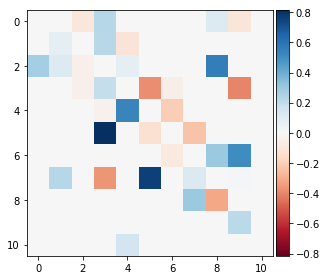

In [22]:
skimage.io.imshow(env.weight_matrix)

In [26]:
action = numpy.zeros(11 * (2 * 11))

In [47]:
for i in range(1):
    stuff = env.step(action)

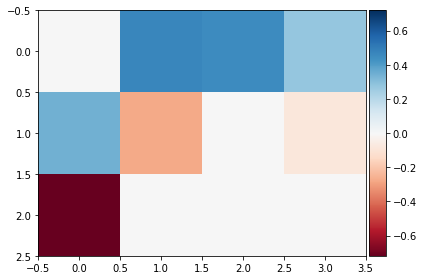

In [48]:
skimage.io.imshow(env.potential_matrix.reshape((3, 4)))